In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)


In [2]:
if params.feat_sel == 'auto': # automatic feature selection, based on feature importance notebook
    
    df_feat_sel = pd.read_csv(params.feat_sel_auto_csv, index_col=0, parse_dates=True)
    
elif params.feat_sel == 'man': # alternative manual feature selection, based on the features selected in the params.py
    
    df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

atr_ratio  atr_ratio_sma    vol_15  bb_width_20  \
2004-01-02 13:07:00  -0.996380      -0.987015 -1.005076    -0.943230   
2004-01-02 13:08:00  -0.994579      -0.986828 -1.001603    -0.937271   
2004-01-02 13:09:00  -0.992906      -0.986557 -0.999187    -0.930276   
2004-01-02 13:10:00  -0.991353      -0.986209 -0.997370    -0.922523   
2004-01-02 13:11:00  -0.989911      -0.985789 -0.995973    -0.914218   
...                        ...            ...       ...          ...   
2025-06-18 20:56:00   0.582507       0.182057  0.348747     0.119570   
2025-06-18 20:57:00   0.641713       0.207647  0.391507     0.184714   
2025-06-18 20:58:00   0.574130       0.230765  0.392142     0.238300   
2025-06-18 20:59:00   0.695123       0.261866  0.692251     0.242399   
2025-06-18 21:00:00   0.828554       0.300607  0.794598     0.233854   

                         r_15       rsi  stoch_k_14     eng_ma         bid  \
2004-01-02 13:07:00 -0.009476 -2.476841   -1.552562  -0.001209    0.763698   
2004-01-02 13:08:00 -0.017401 -2.476841   -1.552562  -0.001209    0.763681   
2004-01-02 13:09:00 -0.025327 -2.476841   -1.552562  -0.001209    0.763664   
2004-01-02 13:10:00 -0.033253 -2.476841   -1.552562  -0.001209    0.763647   
2004-01-02 13:11:00 -0.041178 -2.476841   -1.552562  -0.001209    0.763631   
...                       ...       ...         ...        ...         ...   
2025-06-18 20:56:00  1.315228  0.811095    0.354296  12.115664  196.667400   
2025-06-18 20:57:00  1.113128  0.539711    0.426843  12.401440  196.527500   
2025-06-18 20:58:00  0.827243  0.530165    0.381683  12.401440  196.522500   
2025-06-18 20:59:00 -0.093724 -0.151391   -0.182061   9.257911  196.092800   
2025-06-18 21:00:00  0.661771  0.222017   -0.321780   8.514895  196.392600   

                            ask    signal  
2004-01-02 13:07:00    0.764840  0.069210  
2004-01-02 13:08:00    0.764824  0.073291  
2004-01-02 13:09:00    0.764807  0.077619  
2004-01-02 13:10:00    0.764790  0.082208  
2004-01-02 13:11:00    0.764773  0.087074  
...                         ...       ...  
2025-06-18 20:56:00  196.962600  0.417935  
2025-06-18 20:57:00  196.822500  0.368513  
2025-06-18 20:58:00  196.817500  0.365417  
2025-06-18 20:59:00  196.387200  0.280949  
2025-06-18 21:00:00  196.687400  0.202951  

[3563215 rows x 11 columns]

In [3]:
print('executing <build_lstm_tensors>...')
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

print('executing <chronological_split>...')
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

# how many calendar-days in each split?
print("Days →",
      f"train={len(train_loader.dataset)},",
      f"val={len(val_loader.dataset)},",
      f"test={len(test_loader.dataset)}")

# how many sliding-windows in each split?
print("Windows →",
      f"train={train_loader.dataset.X.shape[0]},",
      f"val={val_loader.dataset.X.shape[0]},",
      f"test={test_loader.dataset.X.shape[0]}")

# how many batches per loader?
print("Batches →",
      f"train={len(train_loader)},",
      f"val={len(val_loader)},",
      f"test={len(test_loader)}")

executing <build_lstm_tensors>...
Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

executing <chronological_split>...
executing <split_to_day_datasets>...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days → train=3808, val=783, test=809
Windows → train=1696435, val=353133, test=364859
Batches → train=119, val=783, test=809


Loading checkpoint: trainings/AAPL_0.2443.pth

Hyperparameters:
{'ATT_DROPOUT': 0.2,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'CLS_LOSS_WEIGHT': 0.05,
 'DROPOUT_LONG': 0.3,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 6,
 'ETA_MIN': 5e-06,
 'HUBER_BETA': 0.1,
 'INITIAL_LR': 0.0001,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 3,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 96,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


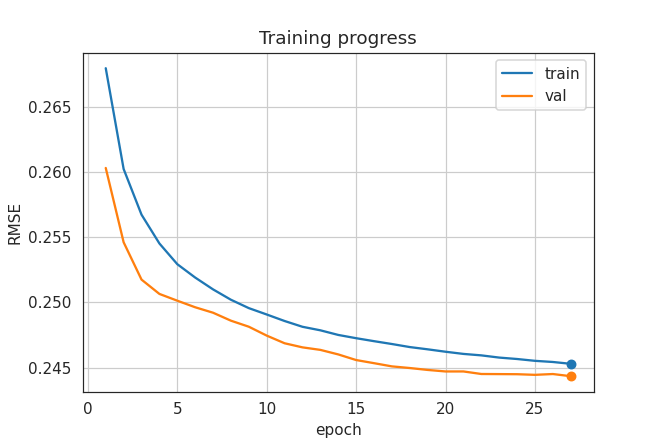


Train metrics: {'rmse': 0.2452925443649292, 'mae': 0.1899121105670929, 'r2': 0.2663048505783081, 'acc': 0.5167018175125122, 'prec': 0.31023600697517395, 'rec': 0.7842815518379211, 'f1': 0.44460204243659973, 'auroc': 0.6627328395843506}
 Val metrics: {'rmse': 0.24434220790863037, 'mae': 0.18198004364967346, 'r2': 0.21347415447235107, 'acc': 0.5658378005027771, 'prec': 0.2915500998497009, 'rec': 0.5812650918960571, 'f1': 0.3883247971534729, 'auroc': 0.5919132232666016}


DualMemoryLSTM(
  (conv): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(8, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [4]:
device = params.device

# 1) Pick the best checkpoint file
model_path = min(
    Path(params.models_folder).glob(f"{params.ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print("Loading checkpoint:", model_path)

# 2) Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# 3) Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# 4) Reinstantiate a *clean* model in CPU memory
model_best = models.DualMemoryLSTM(
    n_feats       = X.shape[-1],    
    short_units   = ckpt["hparams"]["SHORT_UNITS"],
    long_units    = ckpt["hparams"]["LONG_UNITS"],
    dropout_short = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long  = ckpt["hparams"]["DROPOUT_LONG"],
    att_heads     = ckpt["hparams"]["ATT_HEADS"],
    att_drop      = ckpt["hparams"]["ATT_DROPOUT"]
)

# 5) Load *only* the weight tensors into that fresh model
model_best.load_state_dict(ckpt["model_state_dict"])

# 6) Finally—and only now—move to GPU (or keep on CPU)
model_best.to(device)
model_best.eval()

# 7) Ready for inference!
model_best


In [5]:
# -----------------------------------------------------------------------------
# Helper: extract the true signal 'y' from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([
        batch[1].cpu().numpy().ravel()
        for batch in loader
    ])

# pull out validation & test targets
y_val  = extract_y(val_loader)
y_test = extract_y(test_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE:
#    – predict 0 always → RMSE_zero = sqrt(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_val  = np.sqrt(np.mean(y_val ** 2))
rmse_zero_test = np.sqrt(np.mean(y_test ** 2))

print(f"Zero‐forecast RMSE (predict 0) → val:  {rmse_zero_val:.6f}")
print(f"                            test: {rmse_zero_test:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std of val/test signals
#    – and report the mean‐predictor baseline (RMSE=std,   R²=0)
# -----------------------------------------------------------------------------
for split_name, y in [("Validation", y_val), ("Test", y_test)]:
    mean   = y.mean()
    std    = y.std(ddof=0)      # population std = sqrt(var)
    var    = std ** 2
    rmse_m = std               # RMSE_baseline = std(y)
    
    print(f"{split_name} target stats:")
    print(f"  mean = {mean:.4f}, var = {var:.4f}, std = {std:.4f}")
    print(f"{split_name} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_m:.6f}")
    print("  R²_baseline    = 0.00\n")


Zero‐forecast RMSE (predict 0) → val:  0.414883
                            test: 0.399581

Validation target stats:
  mean = 0.3102, var = 0.0759, std = 0.2755
Validation mean‐predictor baseline:
  RMSE_baseline = 0.275513
  R²_baseline    = 0.00

Test target stats:
  mean = 0.3000, var = 0.0697, std = 0.2640
Test mean‐predictor baseline:
  RMSE_baseline = 0.263961
  R²_baseline    = 0.00



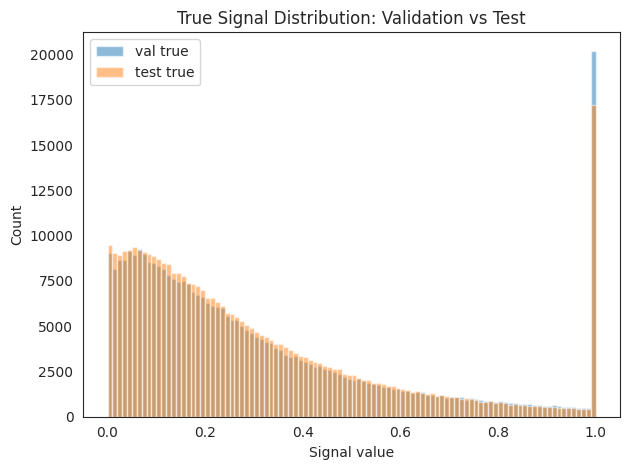

In [6]:
# Visualize the true‐signal distributions on validation vs. test
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.hist(y_test, bins=100, alpha=0.5, label="test true")

plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Validation vs Test")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
def make_preds_and_eval(model, loader, device, split_name: str):
    """
    Run inference over a DataLoader for a stateful CNN→BiLSTM→Attention→BiLSTM model 
    with three heads (regression, binary, ternary), compute metrics, and collect predictions.

    Functionality:
      1) Put model in eval mode and reset LSTM hidden states.
      2) Create torchmetrics objects for:
         - regression: RMSE, MAE, R2
         - binary (sig > threshold): accuracy, precision, recall, F1, AUROC
         - ternary (down/flat/up): multiclass accuracy, precision, recall, F1, AUROC
      3) For each batch in loader (no grad):
         a) Unpack padded sequences, move to device.
         b) For each sequence in the batch:
            • Slice to its true length.
            • Reset or carry LSTM states on day rollover.
            • Forward pass → raw_reg, raw_bin, raw_ter logits.
            • Sigmoid‐activate the regression head so pr ∈ [0,1].
            • Sigmoid/softmax the other heads for probabilities.
            • Update all metrics on the unpadded windows.
            • Append pr to the predictions list.
      4) After looping, compute final metric values.
      5) Print metrics in the format:
         R: … | B: … | T: …
      6) Return (metrics_dict, concatenated_predictions).

    Returns:
      metrics_dict: Dict[str, float] of computed metrics.
      all_preds:    numpy array of all sigmoid’d regression outputs.
    """
    # 1) Prepare model
    model.to(device).eval()
    model.h_short = model.h_long = None

    # 2) Instantiate metrics on target device
    thr        = 0.5
    rmse_m     = torchmetrics.MeanSquaredError(squared=False).to(device)
    mae_m      = torchmetrics.MeanAbsoluteError().to(device)
    r2_m       = torchmetrics.R2Score().to(device)

    acc_m      = torchmetrics.classification.BinaryAccuracy(threshold=thr).to(device)
    prec_m     = torchmetrics.classification.BinaryPrecision(threshold=thr).to(device)
    rec_m      = torchmetrics.classification.BinaryRecall(threshold=thr).to(device)
    f1_m       = torchmetrics.classification.BinaryF1Score(threshold=thr).to(device)
    auc_m      = torchmetrics.classification.BinaryAUROC().to(device)

    ter_acc_m  = torchmetrics.classification.MulticlassAccuracy(num_classes=3).to(device)
    ter_prec_m = torchmetrics.classification.MulticlassPrecision(num_classes=3, average="macro").to(device)
    ter_rec_m  = torchmetrics.classification.MulticlassRecall(num_classes=3, average="macro").to(device)
    ter_f1_m   = torchmetrics.classification.MulticlassF1Score(num_classes=3, average="macro").to(device)
    ter_auc_m  = torchmetrics.classification.MulticlassAUROC(num_classes=3, average="macro").to(device)

    # Reset all metrics
    for m in (
        rmse_m, mae_m, r2_m,
        acc_m, prec_m, rec_m, f1_m, auc_m,
        ter_acc_m, ter_prec_m, ter_rec_m, ter_f1_m, ter_auc_m
    ):
        m.reset()

    all_preds = []
    prev_day  = None

    # 3) Loop over batches without gradient tracking
    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # Unpack batch (11‐tuple or 8‐tuple)
            if len(batch) == 11:
                xb, y_reg, y_bin, y_ret, y_ter, rc, rb, ra, wd, ts_list, lengths = batch
            else:
                xb, y_reg, y_bin, y_ret, y_ter, wd, ts_list, lengths = batch

            # Move to device
            xb    = xb.to(device, non_blocking=True)
            y_reg = y_reg.to(device, non_blocking=True)
            y_bin = y_bin.to(device, non_blocking=True)
            y_ret = y_ret.to(device, non_blocking=True)
            y_ter = y_ter.to(device, non_blocking=True)
            wd    = wd.to(device, non_blocking=True)

            B = xb.size(0)
            for i in range(B):
                W_true = lengths[i]
                day_id = int(wd[i].item())

                # reset or carry LSTM states on new day
                model.reset_short()
                if prev_day is not None and day_id < prev_day:
                    model.reset_long()
                prev_day = day_id

                # Slice sequences to true length
                x_day = xb[i, :W_true]
                y_day = y_reg[i, :W_true].view(-1)
                bin_t = y_bin[i, :W_true].view(-1)
                ter_t = y_ter[i, :W_true].view(-1)

                # Forward pass to get raw logits
                raw_reg, raw_bin, raw_ter = model(x_day)

                # ← FIX: apply sigmoid so regression outputs ∈ [0,1]
                pr = torch.sigmoid(raw_reg[..., -1, 0])    # (W_true,)

                # Binary & ternary probabilities
                pb = torch.sigmoid(raw_bin[..., -1, 0])     # (W_true,)
                pt = torch.softmax(raw_ter[..., -1, :], dim=-1)  # (W_true,3)

                # Update metrics
                rmse_m.update(pr, y_day)
                mae_m .update(pr, y_day)
                r2_m  .update(pr, y_day)

                acc_m .update(pb,  bin_t)
                prec_m.update(pb,  bin_t)
                rec_m .update(pb,  bin_t)
                f1_m  .update(pb,  bin_t)
                auc_m .update(pb,  bin_t)

                ter_acc_m .update(pt, ter_t)
                ter_prec_m.update(pt, ter_t)
                ter_rec_m .update(pt, ter_t)
                ter_f1_m  .update(pt, ter_t)
                ter_auc_m .update(pt, ter_t)

                # Collect predictions
                all_preds.append(pr.cpu().numpy())

    # 4) Compute and gather final metrics
    metrics = {
        "rmse":  rmse_m.compute().item(),
        "mae":   mae_m.compute().item(),
        "r2":    r2_m.compute().item(),
        "acc":   acc_m.compute().item(),
        "prec":  prec_m.compute().item(),
        "rec":   rec_m.compute().item(),
        "f1":    f1_m.compute().item(),
        "auroc": auc_m.compute().item(),
        "t_acc":  ter_acc_m.compute().item(),
        "t_prec": ter_prec_m.compute().item(),
        "t_rec":  ter_rec_m.compute().item(),
        "t_f1":   ter_f1_m.compute().item(),
        "t_auc":  ter_auc_m.compute().item()
    }

    # 5) Print in the R | B | T format
    print(
        f"{split_name}→ "
        f'"R": RMSE={metrics["rmse"]:.5f} MAE={metrics["mae"]:.5f} R2={metrics["r2"]:.4f} | '
        f'"B": Acc={metrics["acc"]:.4f} Prec={metrics["prec"]:.4f} Rec={metrics["rec"]:.4f} '
           f'F1={metrics["f1"]:.4f} AUROC={metrics["auroc"]:.4f} | '
        f'"T": Acc={metrics["t_acc"]:.4f} Prec={metrics["t_prec"]:.4f} Rec={metrics["t_rec"]:.4f} '
           f'F1={metrics["t_f1"]:.4f} AUROC={metrics["t_auc"]:.4f}'
    )

    # Return metrics dict and concatenated predictions
    return metrics, np.concatenate(all_preds, axis=0)


In [8]:
# Run evaluation on all three splits
train_metrics, train_preds = make_preds_and_eval(
    model_best, train_loader, device, split_name="TRAIN"
)
val_metrics, val_preds     = make_preds_and_eval(
    model_best, val_loader,   device, split_name="VALID"
)
test_metrics, test_preds   = make_preds_and_eval(
    model_best, test_loader,  device, split_name="TEST"
)

print("\nPredictions lengths:")
print(f"  Train: {len(train_preds)}")
print(f"  Valid: {len(val_preds)}")
print(f"  Test : {len(test_preds)}")


TRAIN:   0%|          | 0/119 [00:00<?, ?batch/s]

TRAIN→ "R": RMSE=0.25291 MAE=0.18116 R2=0.2200 | "B": Acc=0.5629 Prec=0.3407 Rec=0.8255 F1=0.4823 AUROC=0.7250 | "T": Acc=0.3748 Prec=0.3329 Rec=0.3748 F1=0.0044 AUROC=0.3563


VALID:   0%|          | 0/783 [00:00<?, ?batch/s]

VALID→ "R": RMSE=0.24434 MAE=0.18198 R2=0.2135 | "B": Acc=0.5658 Prec=0.2915 Rec=0.5812 F1=0.3883 AUROC=0.5919 | "T": Acc=0.2438 Prec=0.3333 Rec=0.2438 F1=0.0882 AUROC=0.3905


TEST:   0%|          | 0/809 [00:00<?, ?batch/s]

TEST→ "R": RMSE=0.25351 MAE=0.19808 R2=0.0776 | "B": Acc=0.5184 Prec=0.2411 Rec=0.5333 F1=0.3321 AUROC=0.5430 | "T": Acc=0.2789 Prec=0.3335 Rec=0.2789 F1=0.1435 AUROC=0.4669

Predictions lengths:
  Train: 1696435
  Valid: 353133
  Test : 364859


In [9]:
# Train metrics: {'rmse': 0.2564132809638977, 'mae': 0.18174372613430023, 'r2': 0.1271190643310547, 'acc': 0.827835202217102, 'prec': 0.5648394227027893, 'rec': 0.123975969851017, 'f1': 0.20332448184490204, 'auroc': 0.7604720592498779}
#  Val metrics: {'rmse': 0.2612327039241791, 'mae': 0.1788761168718338, 'r2': 0.02456080913543701, 'acc': 0.8381752967834473, 'prec': 0.6197602152824402, 'rec': 0.11496271193027496, 'f1': 0.19394879043102264, 'auroc': 0.776253879070282}

In [10]:
def add_preds_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds:   np.ndarray,
    test_preds:  np.ndarray,
    end_times_tr:  np.ndarray,   # timestamps for training-window ends
    end_times_val: np.ndarray,   # timestamps for validation-window ends
    end_times_te:  np.ndarray    # timestamps for test-window ends
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Copy minute‐bar DataFrame and append:
         • 'pred_signal' (continuous model output at each window end)
         • 'close_mid'    (mid‐price from bid & ask for sim price)
    2) Build three timestamp→prediction Series for train/val/test.
    3) Stamp each Series into df2['pred_signal'], warning on missing indices.
    4) Split df2 into:
         • df_trainval: rows with train or val window‐end indices
         • df_test:     rows with test window‐end indices
       and drop any NaNs in 'pred_signal'.
    5) Return (df_trainval, df_test).
    """
    # 1) Copy & initialize pred_signal + mid‐price
    df2 = df.copy()
    df2["pred_signal"] = np.nan
    # mid‐price for trade simulation
    df2["close_mid"] = (df2["bid"] + df2["ask"]) / 2

    # 2) Build prediction Series with DatetimeIndex
    s_tr  = pd.Series(train_preds, index=pd.DatetimeIndex(end_times_tr))
    s_val = pd.Series(val_preds,   index=pd.DatetimeIndex(end_times_val))
    s_te  = pd.Series(test_preds,  index=pd.DatetimeIndex(end_times_te))

    # internal helper to stamp preds into df2
    def _stamp(series: pd.Series, label: str):
        missing = series.index.difference(df2.index)
        if not missing.empty:
            print(f"⚠️ {label}: {len(missing)} timestamps not found in DataFrame")
        valid = series.index.intersection(df2.index)
        df2.loc[valid, "pred_signal"] = series.loc[valid].values

    # 3) Stamp train, val, test predictions
    _stamp(s_tr,  "Train")
    _stamp(s_val, "Val")
    _stamp(s_te,  "Test")
    print(f"✅ Stamped {len(s_tr)} Train, {len(s_val)} Val, {len(s_te)} Test predictions")

    # 4) Split and drop NaNs in pred_signal
    idx_trval = s_tr.index.union(s_val.index).intersection(df2.index)
    idx_te    = s_te.index.intersection(df2.index)

    df_trainval = df2.loc[idx_trval].dropna(subset=["pred_signal"])
    df_test     = df2.loc[idx_te].dropna(subset=["pred_signal"])

    print(f"➡️  train+val: {len(df_trainval)} rows, test: {len(df_test)} rows")
    return df_trainval, df_test


In [11]:
# 1) Stamp predictions and mid‐price, then split into train+val & test
df_trainval, df_test = add_preds_and_split(
    df            = df_feat_sel,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

# 2) Persist CSVs
print("Saving test CSV…")
df_test.to_csv(params.test_csv)
print("Saving train+val CSV…")
df_trainval.to_csv(params.trainval_csv)

df_test

✅ Stamped 1696435 Train, 353133 Val, 364859 Test predictions
➡️  train+val: 2049568 rows, test: 364859 rows
Saving test CSV…
Saving train+val CSV…


atr_ratio  atr_ratio_sma    vol_15  bb_width_20  \
2022-03-29 13:30:00  -0.020215       0.102350 -0.005869     0.710601   
2022-03-29 13:31:00  -0.074959       0.085293 -0.000150     0.742131   
2022-03-29 13:32:00  -0.101415       0.071177 -0.001433     0.761537   
2022-03-29 13:33:00  -0.130193       0.055510 -0.106603     0.687975   
2022-03-29 13:34:00  -0.127354       0.040703 -0.106624     0.623671   
...                        ...            ...       ...          ...   
2025-06-18 20:56:00   0.582507       0.182057  0.348747     0.119570   
2025-06-18 20:57:00   0.641713       0.207647  0.391507     0.184714   
2025-06-18 20:58:00   0.574130       0.230765  0.392142     0.238300   
2025-06-18 20:59:00   0.695123       0.261866  0.692251     0.242399   
2025-06-18 21:00:00   0.828554       0.300607  0.794598     0.233854   

                         r_15       rsi  stoch_k_14     eng_ma       bid  \
2022-03-29 13:30:00  1.515197  0.888665    1.323720  14.801952  176.7573   
2022-03-29 13:31:00  1.186847  0.813026    1.301504  14.744797  176.7373   
2022-03-29 13:32:00  1.166258  0.832177    1.220748  14.516177  176.7473   
2022-03-29 13:33:00  1.125537  0.632014    1.110632  13.773161  176.6974   
2022-03-29 13:34:00  1.186779  0.741043    1.068810  13.201611  176.7473   
...                       ...       ...         ...        ...       ...   
2025-06-18 20:56:00  1.315228  0.811095    0.354296  12.115664  196.6674   
2025-06-18 20:57:00  1.113128  0.539711    0.426843  12.401440  196.5275   
2025-06-18 20:58:00  0.827243  0.530165    0.381683  12.401440  196.5225   
2025-06-18 20:59:00 -0.093724 -0.151391   -0.182061   9.257911  196.0928   
2025-06-18 21:00:00  0.661771  0.222017   -0.321780   8.514895  196.3926   

                          ask    signal  pred_signal  close_mid  
2022-03-29 13:30:00  177.0227  0.131620     0.575512    176.890  
2022-03-29 13:31:00  177.0027  0.083321     0.598184    176.870  
2022-03-29 13:32:00  177.0127  0.049625     0.598628    176.880  
2022-03-29 13:33:00  176.9626  0.050106     0.599009    176.830  
2022-03-29 13:34:00  177.0127  0.062705     0.595653    176.880  
...                       ...       ...          ...        ...  
2025-06-18 20:56:00  196.9626  0.417935     0.498103    196.815  
2025-06-18 20:57:00  196.8225  0.368513     0.526532    196.675  
2025-06-18 20:58:00  196.8175  0.365417     0.543831    196.670  
2025-06-18 20:59:00  196.3872  0.280949     0.540239    196.240  
2025-06-18 21:00:00  196.6874  0.202951     0.504677    196.540  

[364859 rows x 13 columns]

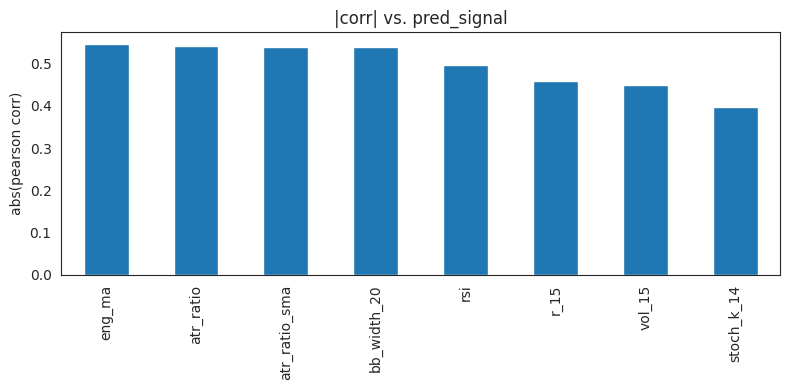

eng_ma           0.546676
atr_ratio        0.542715
atr_ratio_sma    0.539543
bb_width_20      0.538631
rsi              0.496727
r_15             0.458506
vol_15           0.449877
stoch_k_14       0.397570
dtype: float64

In [12]:
# Quick correlation check
# This measures the absolute Pearson corr between each feature and your pred_signal on the test split

# Identify feature columns (drop non-inputs)
feat_cols = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_mid")
]

# Compute absolute corr(feature, pred_signal)
corrs = df_test[feat_cols] \
    .corrwith(df_test["pred_signal"]) \
    .abs() \
    .sort_values(ascending=False)

# Bar plot
corrs.plot.bar(figsize=(8,4), title="|corr| vs. pred_signal")
plt.ylabel("abs(pearson corr)")
plt.tight_layout()
plt.show()

corrs

IG windows:   0%|          | 0/50 [00:00<?, ?it/s]

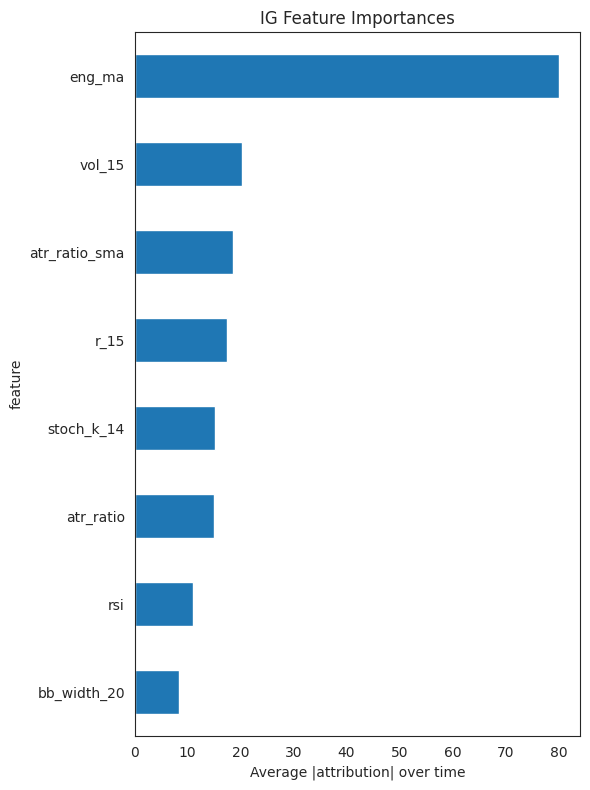

feature  importance
7         eng_ma   80.065482
2         vol_15   20.338231
1  atr_ratio_sma   18.581862
4           r_15   17.481360
6     stoch_k_14   15.114248
0      atr_ratio   15.057540
5            rsi   10.925646
3    bb_width_20    8.440413

In [17]:
# — Integrated-Gradients (Captum) AFTER add_preds_and_split and loading model_best —
feature_names = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_mid")
]

imp_df = feats.ig_feature_importance(
    model_best,
    test_loader,
    feature_names,
    device,
    n_samples=50,   # how many windows to sample
    n_steps=20       # fewer steps → less mem & time
)

# Simple horizontal bar plot of the top 20
plt.figure(figsize=(6,8))
imp_df \
    .set_index("feature")["importance"] \
    .sort_values() \
    .plot.barh(color="C0")
plt.title("IG Feature Importances")
plt.xlabel("Average |attribution| over time")
plt.tight_layout()
plt.show()

imp_df


In [18]:
# Compute Descriptive Statistics
# Statistics show whether the model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

count      mean       std       min       25%       50%  \
signal       364859.0  0.299982  0.263961  0.000000  0.099897  0.219751   
pred_signal  364859.0  0.330480  0.148409  0.048214  0.224439  0.296941   

                  75%       max     range  pearson_r_with_other  
signal       0.419164  1.000000  1.000000              0.362031  
pred_signal  0.405718  0.948495  0.900281              0.362031

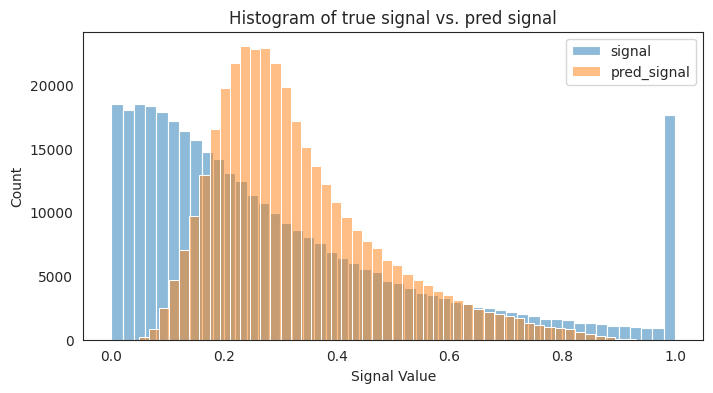

In [19]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

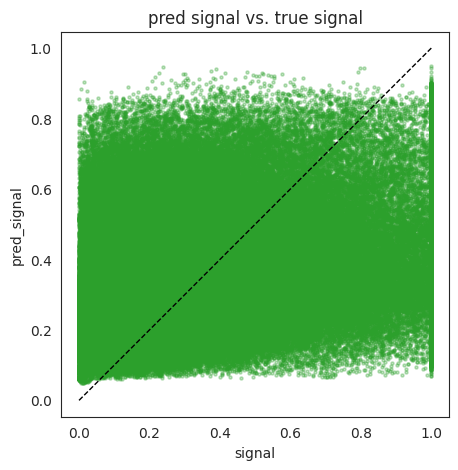

In [20]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

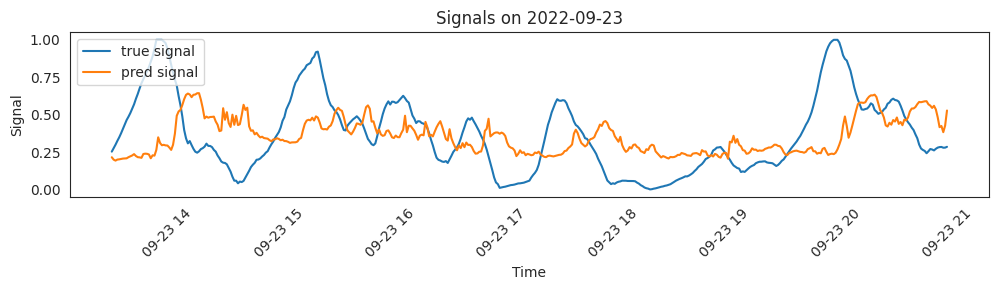

In [21]:
# pick a random trading day from the test set
all_days = df_test.index.normalize().unique()
day      = np.random.choice(all_days)

# mask for that day
mask = df_test.index.normalize() == day

# Plot true vs. predicted signal on the random day
plt.figure(figsize=(10, 3))
plt.plot(df_test.index[mask], df_test.loc[mask, 'signal'],      label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask, 'pred_signal'], label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {pd.to_datetime(day).date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

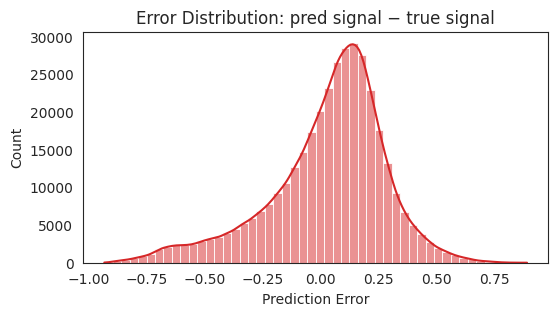

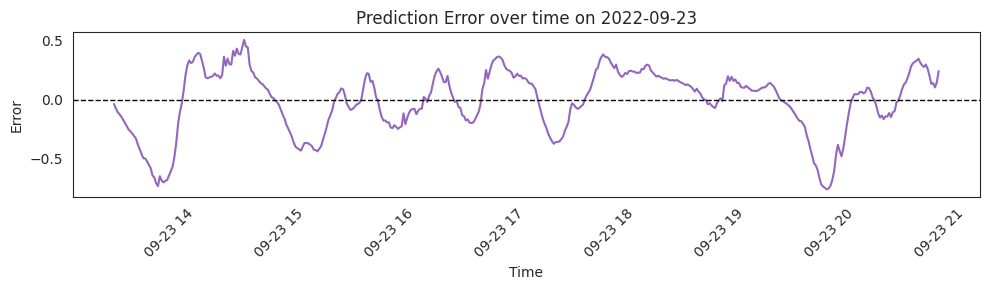

In [22]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {pd.to_datetime(day).date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.

# Simulate per‐day to avoid cross‐midnight state carry‐over
sim_results = {}
groups     = list(df_test.groupby(df_test.index.normalize()))
print(f"Processing {len(groups)} days of predictions…")

for day, df_day in tqdm(groups, desc="Generate+Simulate"):
    # a) Generate discrete actions from the continuous signal
    df_actions = trades.generate_trade_actions(
        df                = df_day,
        col_signal        = "pred_signal", # name for the signal column to use
        col_action        = "pred_action", # name for the trade-action column to add
        buy_threshold     = params.pred_threshold_tick,
        trailing_stop_pct = params.trailing_stop_pred_tick,
        sess_start        = params.sess_start,
        col_close         = "close_mid"    # name of the column to use for price
    )

    # b) Run the backtest on this single‐day DataFrame
    single_result = trades.simulate_trading(
        results_by_day_sign = {day: (df_actions, [])},
        col_action          = "pred_action",
        sess_start          = params.sess_start,
        sess_end            = params.sess_end,
        ticker              = params.ticker
    )
    sim_results.update(single_result)

# final: sim_results holds each day → (df_sim, trades, stats)


Processing 809 days of predictions…


Generate+Simulate:   0%|          | 0/809 [00:00<?, ?it/s]


Plotting days in 2023-09:



=== Performance for 2023-09-01 00:00:00 ===
Buy & Hold Return ($): -0.449
Strategy Return ($): -2.507
Trades Returns ($): [-1.383, 0.283, -0.409, -0.244, -0.293, -0.414, -0.183, 0.136]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-05 00:00:00 ===
Buy & Hold Return ($): 1.167
Strategy Return ($): -0.849
Trades Returns ($): [1.067, -0.344, -0.315, -0.374, -0.42, -0.235, -0.23]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-06 00:00:00 ===
Buy & Hold Return ($): -5.819
Strategy Return ($): -6.103
Trades Returns ($): [-0.922, -3.879, -1.02, -0.229, -0.3, 0.247]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-07 00:00:00 ===
Buy & Hold Return ($): 2.935
Strategy Return ($): 2.935
Trades Returns ($): [2.935]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-08 00:00:00 ===
Buy & Hold Return ($): -0.968
Strategy Return ($): -2.181
Trades Returns ($): [-0.039, -0.334, 0.108, -0.475, -0.988, -0.447, -0.007]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-11 00:00:00 ===
Buy & Hold Return ($): -1.007
Strategy Return ($): -3.318
Trades Returns ($): [-1.878, -0.299, -0.243, 0.472, -0.239, -0.443, -0.369, -0.32]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-12 00:00:00 ===
Buy & Hold Return ($): -3.195
Strategy Return ($): -3.505
Trades Returns ($): [-2.975, -0.531]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-13 00:00:00 ===
Buy & Hold Return ($): -2.836
Strategy Return ($): -3.781
Trades Returns ($): [-1.581, -0.323, -0.727, -0.246, -0.901]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-14 00:00:00 ===
Buy & Hold Return ($): 1.605
Strategy Return ($): -0.358
Trades Returns ($): [1.268, 0.211, -0.433, -0.259, -0.518, -0.274, -0.093, -0.258]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-15 00:00:00 ===
Buy & Hold Return ($): -1.198
Strategy Return ($): -2.975
Trades Returns ($): [-1.308, -0.324, -0.408, -0.391, -0.031, -0.353, -0.506, 0.347]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-18 00:00:00 ===
Buy & Hold Return ($): 0.72
Strategy Return ($): -0.132
Trades Returns ($): [1.777, -0.409, -0.359, -0.38, -0.448, -0.316]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-19 00:00:00 ===
Buy & Hold Return ($): 1.127
Strategy Return ($): -1.013
Trades Returns ($): [-0.608, 0.224, -0.187, 0.956, -0.312, -0.558, -0.383, -0.147]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-20 00:00:00 ===
Buy & Hold Return ($): -4.101
Strategy Return ($): -6.476
Trades Returns ($): [-0.842, -1.492, -0.377, -0.291, -0.327, -0.396, -1.1, -1.653]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-21 00:00:00 ===
Buy & Hold Return ($): -1.562
Strategy Return ($): -2.689
Trades Returns ($): [-0.503, -0.382, -0.399, -0.323, -0.362, -0.254, -0.466]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-22 00:00:00 ===
Buy & Hold Return ($): 0.358
Strategy Return ($): -0.199
Trades Returns ($): [0.058, -0.257]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-25 00:00:00 ===
Buy & Hold Return ($): 0.94
Strategy Return ($): -0.563
Trades Returns ($): [0.989, -0.444, -0.373, -0.294, -0.394, -0.404, -0.359, 0.717]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-26 00:00:00 ===
Buy & Hold Return ($): -3.04
Strategy Return ($): -4.008
Trades Returns ($): [-1.815, -0.53, -0.576, -0.277, -0.353, -0.453, -0.003]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-27 00:00:00 ===
Buy & Hold Return ($): -2.852
Strategy Return ($): -3.411
Trades Returns ($): [-2.508, -0.465, -0.494, -0.521, 0.577]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-28 00:00:00 ===
Buy & Hold Return ($): 2.376
Strategy Return ($): 2.295
Trades Returns ($): [2.656, -0.361]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-29 00:00:00 ===
Buy & Hold Return ($): -1.258
Strategy Return ($): -1.795
Trades Returns ($): [-0.348, -0.33, -0.409, -0.707]

---------------------------------------------------------------------------------------------------------------------------------------------------


Overall Summary (2023-09-01 = 189.7672 → 2023-09-29 = 171.0116)

One-time buy&hold gain: -18.756
Buy & Hold – each day ($): -17.057
Strategy Return ($): -40.633
Trades Count: 117
Strategy return per trade: -0.347
Num. trading days: 20
Strategy return per trading day: -2.032


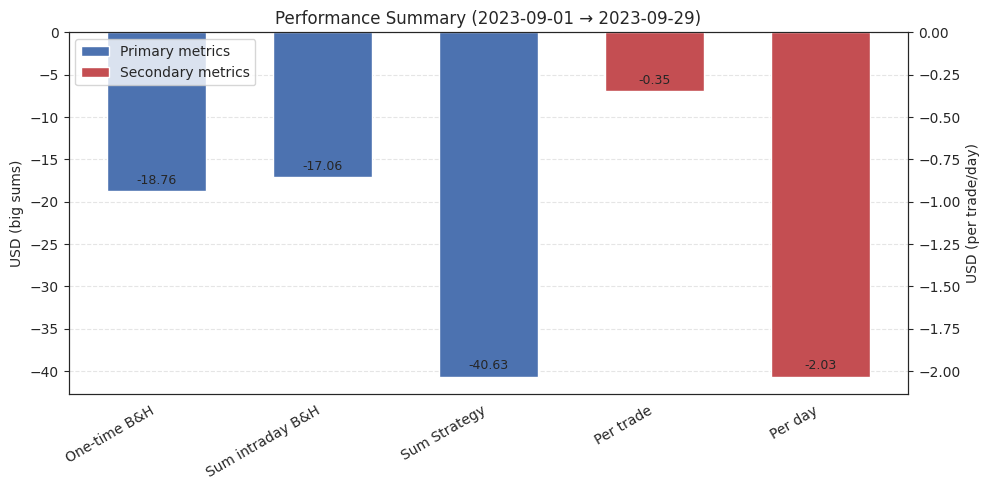


Overall Summary (2022-03-29 = 177.0727 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 19.320
Buy & Hold – each day ($): -192.076
Strategy Return ($): -1209.825
Trades Count: 4308
Strategy return per trade: -0.281
Num. trading days: 809
Strategy return per trading day: -1.495


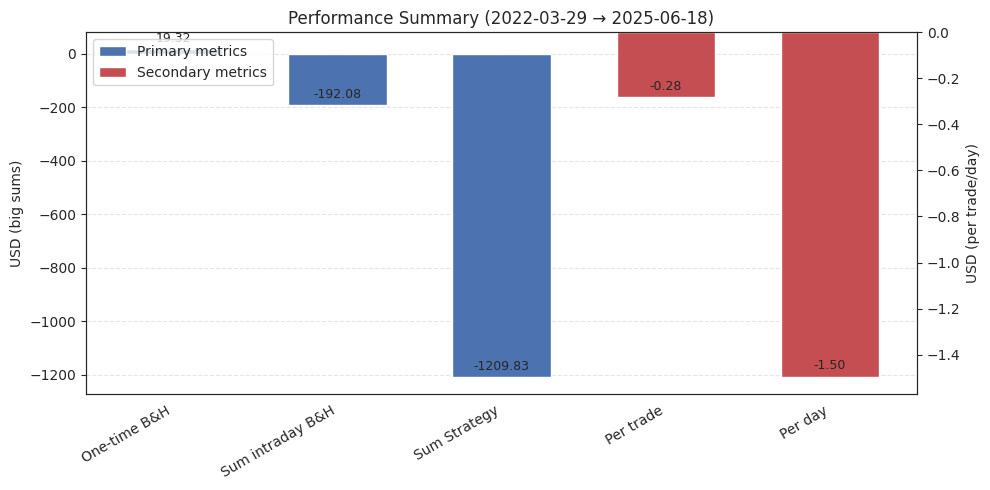

In [24]:
# month to inspect (YYYY-MM)
date_to_test = params.date_to_check

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

feat_sel = df_feat_sel.columns.drop(['bid','ask','signal'])

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats,
            col_close         = 'close_mid',
            features          = feat_sel
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")
        print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)